# Итоговая проектная работа
## Анализ датасета 'Audi'

In [435]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.iolib.summary2 import summary_params
from scipy.stats import t
from scipy.stats import f # F-распределение
from statsmodels.iolib.summary2 import summary_col # вывод подгонки
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import patsy # матрицы регрессионного дизайна
import scipy.stats as stats
import statsmodels.stats.api as sms # тесты
from scipy.stats import chi2 # 𝜒2-распределение

###  Загрузим данные

In [436]:
df = pd.read_csv('https://raw.githubusercontent.com/zhanna11111/homework111111/main/audi.csv')
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


###   Обработка данных

In [437]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


Nan-ов нет

In [438]:
df['model'].unique()

array([' A1', ' A6', ' A4', ' A3', ' Q3', ' Q5', ' A5', ' S4', ' Q2',
       ' A7', ' TT', ' Q7', ' RS6', ' RS3', ' A8', ' Q8', ' RS4', ' RS5',
       ' R8', ' SQ5', ' S8', ' SQ7', ' S3', ' S5', ' A2', ' RS7'],
      dtype=object)

In [439]:
df['year'].unique()

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997])

In [440]:
df['transmission'].unique()

array(['Manual', 'Automatic', 'Semi-Auto'], dtype=object)

In [441]:
df['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid'], dtype=object)

Для точности модели заменем год числами от 1 до 21

In [442]:
df['year'] -= 1997 
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,20,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,19,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,19,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,20,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,22,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,23,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,23,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,23,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,20,19499,Automatic,8646,Petrol,150,47.9,1.4


Для более интересного анализа немного уменьшим корреляцию между колонкой model и price, убрав точную информацию о модели автомобиля, будем работать только с серией (A, Q, S, T, R)

In [443]:
df['model'] = df['model'].str[1]
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A,20,12500,Manual,15735,Petrol,150,55.4,1.4
1,A,19,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A,19,11000,Manual,29946,Petrol,30,55.4,1.4
3,A,20,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A,22,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A,23,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A,23,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A,23,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q,20,19499,Automatic,8646,Petrol,150,47.9,1.4


In [444]:
df['model'].unique()

array(['A', 'Q', 'S', 'T', 'R'], dtype=object)

Теперь закодируем категориальные признаки

In [445]:
area_dummies = pd.get_dummies(df.model)
df = pd.concat([df, area_dummies], axis=1)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,A,Q,R,S,T
0,A,20,12500,Manual,15735,Petrol,150,55.4,1.4,1,0,0,0,0
1,A,19,16500,Automatic,36203,Diesel,20,64.2,2.0,1,0,0,0,0
2,A,19,11000,Manual,29946,Petrol,30,55.4,1.4,1,0,0,0,0
3,A,20,16800,Automatic,25952,Diesel,145,67.3,2.0,1,0,0,0,0
4,A,22,17300,Manual,1998,Petrol,145,49.6,1.0,1,0,0,0,0


In [446]:
area_dummies = pd.get_dummies(df.transmission)
df = pd.concat([df, area_dummies], axis=1)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,Semi-Auto
0,A,20,12500,Manual,15735,Petrol,150,55.4,1.4,1,0,0,0,0,0,1,0
1,A,19,16500,Automatic,36203,Diesel,20,64.2,2.0,1,0,0,0,0,1,0,0
2,A,19,11000,Manual,29946,Petrol,30,55.4,1.4,1,0,0,0,0,0,1,0
3,A,20,16800,Automatic,25952,Diesel,145,67.3,2.0,1,0,0,0,0,1,0,0
4,A,22,17300,Manual,1998,Petrol,145,49.6,1.0,1,0,0,0,0,0,1,0


In [447]:
df = df.rename(columns={"Semi-Auto": 'SemiAuto'})
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,SemiAuto
0,A,20,12500,Manual,15735,Petrol,150,55.4,1.4,1,0,0,0,0,0,1,0
1,A,19,16500,Automatic,36203,Diesel,20,64.2,2.0,1,0,0,0,0,1,0,0
2,A,19,11000,Manual,29946,Petrol,30,55.4,1.4,1,0,0,0,0,0,1,0
3,A,20,16800,Automatic,25952,Diesel,145,67.3,2.0,1,0,0,0,0,1,0,0
4,A,22,17300,Manual,1998,Petrol,145,49.6,1.0,1,0,0,0,0,0,1,0


Так как в датасете очень мало набблюдений с гибридным fuelType, создадим искусственно бинарную колнку, заменив гибрид на дизель

In [448]:
cleanup_nums = {"fuelType": {'Hybrid': 'Diesel'}}
df = df.replace(cleanup_nums)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,SemiAuto
0,A,20,12500,Manual,15735,Petrol,150,55.4,1.4,1,0,0,0,0,0,1,0
1,A,19,16500,Automatic,36203,Diesel,20,64.2,2.0,1,0,0,0,0,1,0,0
2,A,19,11000,Manual,29946,Petrol,30,55.4,1.4,1,0,0,0,0,0,1,0
3,A,20,16800,Automatic,25952,Diesel,145,67.3,2.0,1,0,0,0,0,1,0,0
4,A,22,17300,Manual,1998,Petrol,145,49.6,1.0,1,0,0,0,0,0,1,0


In [449]:
cleanup_nums = {"fuelType": {'Diesel': 0, 'Petrol': 1}}
df = df.replace(cleanup_nums)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,SemiAuto
0,A,20,12500,Manual,15735,1,150,55.4,1.4,1,0,0,0,0,0,1,0
1,A,19,16500,Automatic,36203,0,20,64.2,2.0,1,0,0,0,0,1,0,0
2,A,19,11000,Manual,29946,1,30,55.4,1.4,1,0,0,0,0,0,1,0
3,A,20,16800,Automatic,25952,0,145,67.3,2.0,1,0,0,0,0,1,0,0
4,A,22,17300,Manual,1998,1,145,49.6,1.0,1,0,0,0,0,0,1,0


Данные готовы к применению моделей!

###  Визуализация данных

**Числовые признаки**

<Axes: xlabel='price', ylabel='Count'>

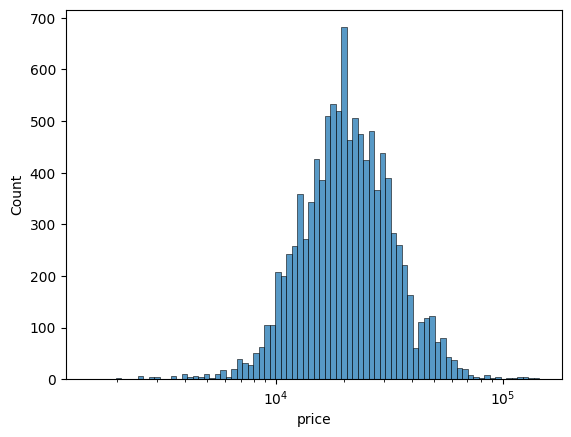

In [450]:
sns.histplot(data=df, x='price', log_scale=True)

<Axes: xlabel='mileage', ylabel='Count'>

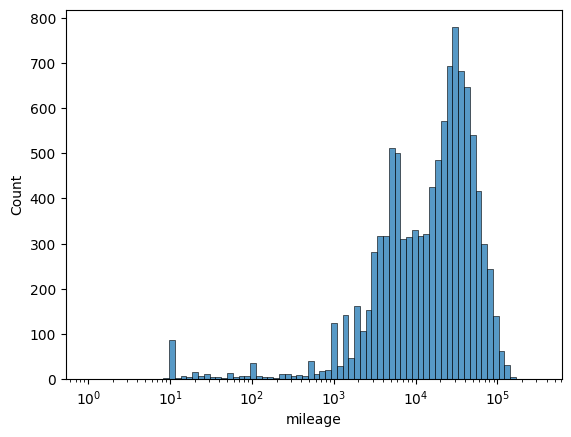

In [451]:
sns.histplot(data=df, x='mileage', log_scale=True)

<Axes: xlabel='tax', ylabel='Count'>

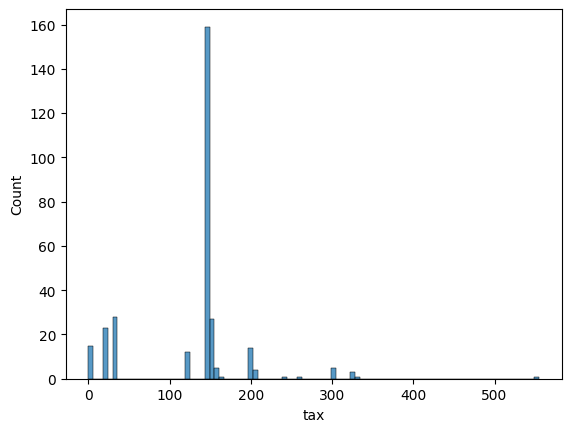

In [452]:
sns.histplot(data=df.sample(300), x='tax')

<Axes: xlabel='mpg', ylabel='Count'>

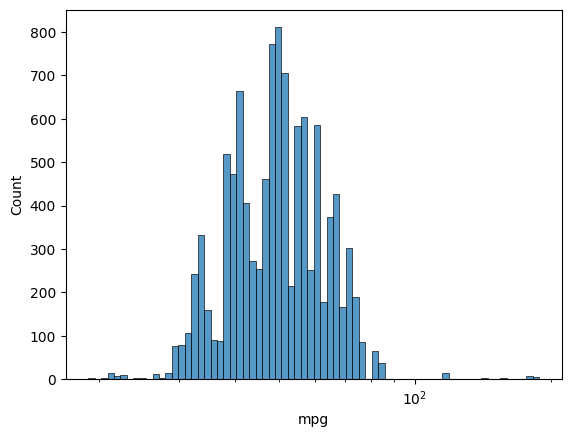

In [453]:
sns.histplot(data=df, x='mpg', log_scale=True)

**Вывод:** в каждом из случаев имеем что-то близкое к нормальному распределению

**Визуализация категориальных признаков**

<Axes: xlabel='model', ylabel='count'>

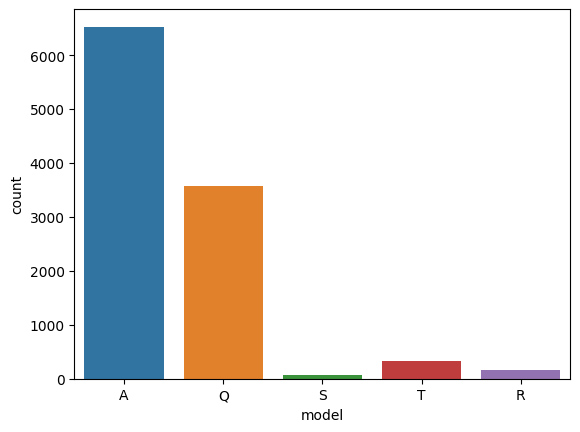

In [454]:
sns.countplot(data=df, x='model')

**Вывод:** серия A сильно выделятся 

<Axes: xlabel='transmission', ylabel='count'>

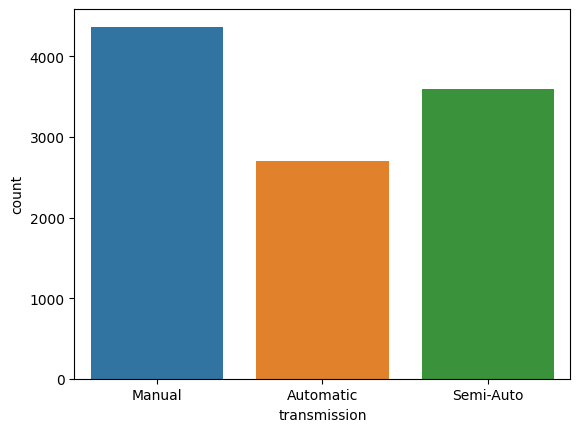

In [455]:
sns.countplot(data=df, x='transmission')

**Вывод:** Видно что значения Manual на процентов 10-15 больше

<Axes: xlabel='fuelType', ylabel='count'>

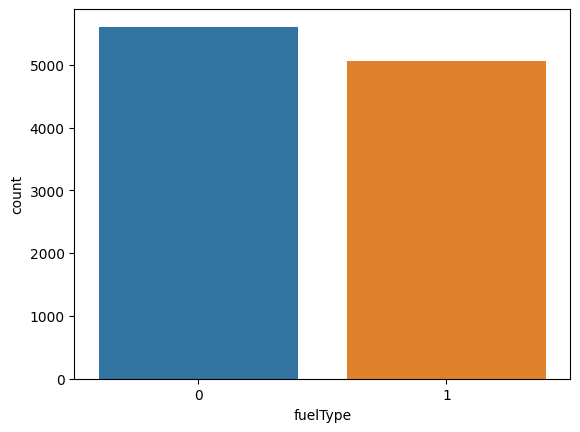

In [456]:
sns.countplot(data=df, x='fuelType')

**Вывод:** Сильный дизбаланс не наблюдается

**Построим несколько графиков для 300 случайных наблюденйи**

<Axes: xlabel='price', ylabel='mileage'>

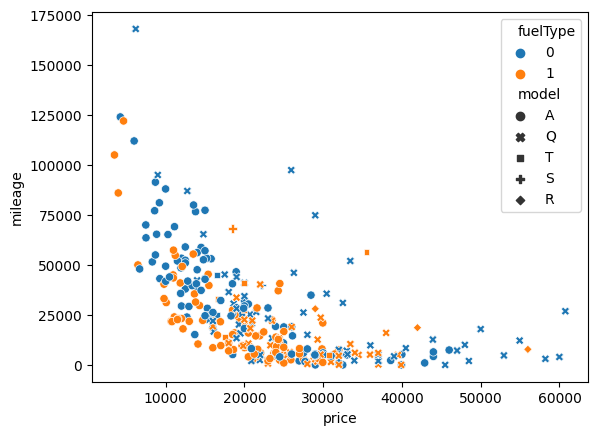

In [457]:
sns.scatterplot(data=df.sample(n = 300), x='price', y='mileage', style='model', hue='fuelType')

<Axes: xlabel='price', ylabel='mileage'>

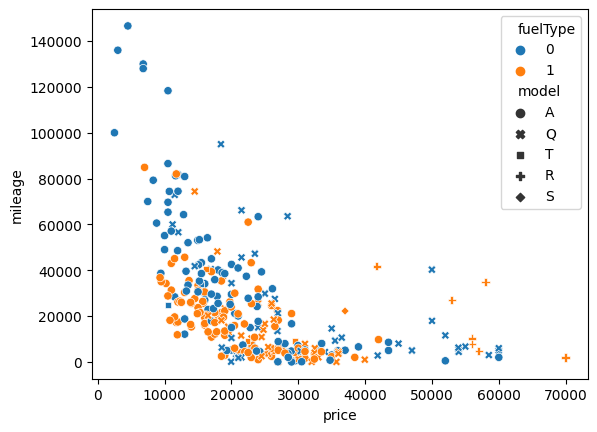

In [458]:
sns.scatterplot(data=df.sample(n = 300), x='price', y='mileage', style='model', hue='fuelType')

<Axes: xlabel='price', ylabel='mileage'>

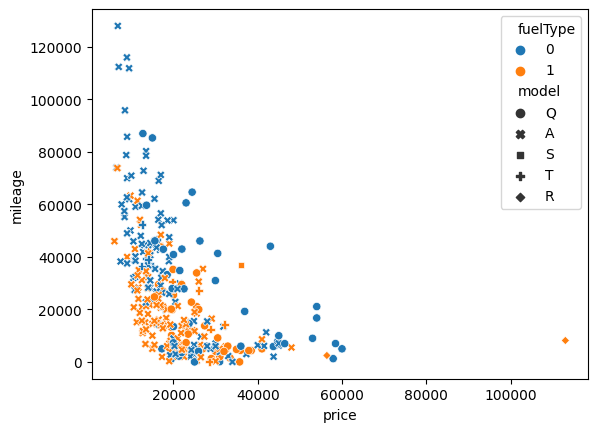

In [459]:
sns.scatterplot(data=df.sample(n = 300), x='price', y='mileage', style='model', hue='fuelType')

**Диаграммы рассеения**

<Axes: xlabel='mileage', ylabel='price'>

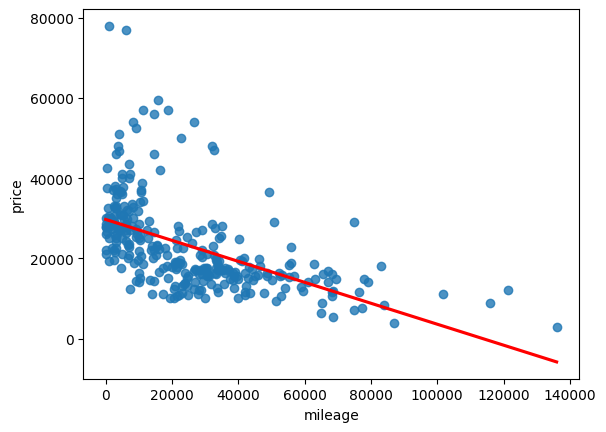

In [460]:
sns.regplot(data=df.sample(n = 300), x='mileage', y='price', ci=None, line_kws={"color": "r"})

**Вывод:** с увелечением пробега цена падает

<Axes: xlabel='tax', ylabel='price'>

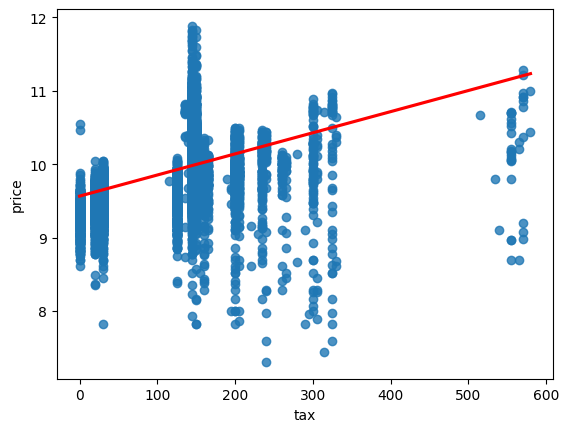

In [461]:
sns.regplot(data=df, x='tax', y=np.log(df['price']), ci=None, line_kws={"color": "r"})

**Вывод:** цена прямопропорциональна налогу

<Axes: xlabel='year', ylabel='price'>

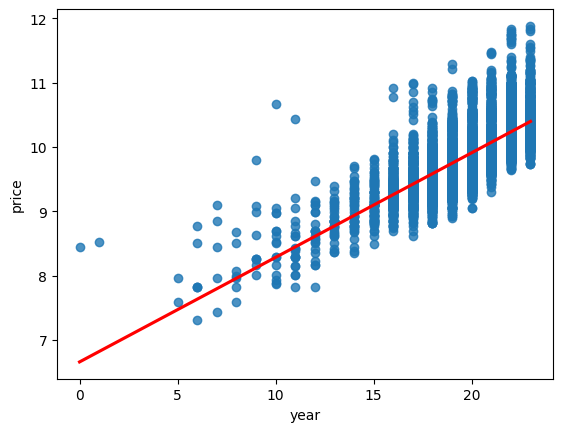

In [462]:
sns.regplot(data=df, x='year', y=np.log(df['price']), ci=None, line_kws={"color": "r"})

**Вывод:** чем новее машина тем она дороже

###  Подгонка модели и спецификация

За целевую переменную берем log(price) чтобы числовие признаки не так сильно расходились между собой,

с такой же логикой возьмем log(mileage)

In [463]:
# специфицируем модель через формулу
mod = smf.ols(formula='np.log(price)~year+np.log(mileage)+fuelType+tax+mpg+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto', data=df).fit()
# Коэфициенты модели с округление
mod.params.round(2)

Intercept          4.66
year               0.13
np.log(mileage)   -0.03
fuelType           0.03
tax                0.00
mpg               -0.00
engineSize         0.30
A                  0.78
Q                  0.93
R                  1.11
S                  0.97
T                  0.88
Automatic          1.60
Manual             1.47
SemiAuto           1.60
dtype: float64

Спецификация:
    
$log(price)=\beta_0+\beta_1year+\beta_2log(mileage)+\beta_3tax+\beta_4mpg+\beta_5engineSize+\beta_6A+\beta_7Q+\beta_8R+\beta_9S+\beta_{10}T+\beta_{11}Automatic+\beta_{12}Manual+\beta_{13}SemiAuto+\beta_{14}fuelType+u$

C подставленными $\beta$:

    
$log(price)=4.66+0.13*year+-0.03*log(mileage)+0*tax+-0*mpg+0.30*engineSize+0.78*A+0.93*Q+1.11*R+0.97*S+0.88*T+1.60*Automatic+1.47*Manual+1.60*SemiAuto$

Интерпретация:
1) Audi с автоматической коробкой передач в среднем дороже на 1.60% 
2) Бензиновые audi дороже в среднем на 0.03%
3) При увелечение пробега на 1% цена падает на 0.03%

###  Вычислим коэффиценты детерминации

In [464]:
# R^2
R2 = mod.rsquared.round(2)
# adj R^2
R2_adj = mod.rsquared_adj.round(2)
print("R^2 =", R2)
print("R^2_adj =", R2_adj)

R^2 = 0.89
R^2_adj = 0.89


**Вывод:** целевая переменная хороршо объясняется предикторными

###  TSS ESS RSS

In [465]:
TSS = mod.centered_tss
ESS = mod.ess
RSS = mod.ssr
print("TSS =", TSS.round(3))
print("ESS =", ESS.round(3))
print("RSS =", RSS.round(3))

TSS = 2365.341
ESS = 2114.017
RSS = 251.324


###  Предсказанное значение и остаток для нескольких наблюдений

In [466]:
ind = np.arange(100, 110)
data = pd.DataFrame({'i': ind, 'Факт': df["price"][ind], 'Fitted': np.exp(mod.predict()[ind]), 'Остаток': df["price"][ind] - mod.predict()[ind]})
data

,i,Факт,Fitted,Остаток
100,100,25000,25340.606422,24989.859837
101,101,31000,34247.960441,30989.558618
102,102,28000,28309.141444,27989.749060
103,103,28000,25237.296706,27989.863922
104,104,21499,24889.521631,21488.877798
105,105,26000,28802.017327,25989.731799
106,106,30000,27734.979108,29989.769550
107,107,17000,15258.897188,16990.367082
108,108,14500,15025.715097,14490.382482
109,109,17500,23129.444589,17489.951138


###  Cтандартная ошибка регрессии

In [467]:
n = len(df["price"])
k = 15
s = np.sqrt(RSS / (n - k - 1))
print("s =", s.round(4))

s = 0.1536


###  Значимсть коэффицентов регрессии

In [468]:
table = mod.summary().tables[1]
df_t = pd.read_html(table.as_html(), header=0, index_col=0)[0] # Эту строку запоминать не нужно
df_t

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.6635,0.023000,202.652,0.000,4.618000,4.709
year,0.1326,0.001000,135.623,0.000,0.131000,0.135
np.log(mileage),-0.0260,0.001000,-18.170,0.000,-0.029000,-0.023
fuelType,0.0332,0.004000,8.040,0.000,0.025000,0.041
tax,0.0001,0.000031,3.470,0.001,0.000046,0.000
mpg,-0.0028,0.000000,-13.814,0.000,-0.003000,-0.002
engineSize,0.2995,0.004000,80.115,0.000,0.292000,0.307
A,0.7757,0.007000,117.312,0.000,0.763000,0.789
Q,0.9254,0.007000,140.446,0.000,0.912000,0.938
R,1.1110,0.013000,86.073,0.000,1.086000,1.136


Вычислим критическое значение для t-теста c уровнем значимости 10%.

In [469]:
alpha = 0.1 # уровень значимости
print('Уровень значимости alpha: ', alpha)
DF = int(mod.df_resid) # число степеней свободы 
t_crit = scipy.stats.t.ppf(1-alpha/2, DF)
print('Критическое значение t_crit: ', t_crit.round(3))

Уровень значимости alpha:  0.1
Критическое значение t_crit:  1.645


In [470]:
df_t['znachimosty'] = df_t.apply(lambda x : 'znachim' if np.abs(x['t']) > t_crit else 'ne znachim', axis = 1 )
df_t

,coef,std err,t,P>|t|,[0.025,0.975],znachimosty
Intercept,4.6635,0.023000,202.652,0.000,4.618000,4.709,znachim
year,0.1326,0.001000,135.623,0.000,0.131000,0.135,znachim
np.log(mileage),-0.0260,0.001000,-18.170,0.000,-0.029000,-0.023,znachim
fuelType,0.0332,0.004000,8.040,0.000,0.025000,0.041,znachim
tax,0.0001,0.000031,3.470,0.001,0.000046,0.000,znachim
mpg,-0.0028,0.000000,-13.814,0.000,-0.003000,-0.002,znachim
engineSize,0.2995,0.004000,80.115,0.000,0.292000,0.307,znachim
A,0.7757,0.007000,117.312,0.000,0.763000,0.789,znachim
Q,0.9254,0.007000,140.446,0.000,0.912000,0.938,znachim
R,1.1110,0.013000,86.073,0.000,1.086000,1.136,znachim


Построим 95% довирительные интервалы для каждого коэффицента

In [471]:
math_eq.conf_int(alpha=0.05)

,0,1
Intercept,4.066337,4.152300
year,0.128743,0.132505
np.log(mileage),-0.022418,-0.016820
tax,-0.000157,-0.000035
mpg,-0.006937,-0.005935
engineSize,0.269560,0.284415
A,0.662240,0.688577
Q,0.790799,0.815774
R,0.985951,1.035107
S,0.820278,0.885436


### Значимость регрессии

In [472]:
# Результаты F-теста на значимость регрессии (тестовая статистика и P-значение)
mod.fvalue.round(3), mod.f_pvalue

(7468.74, 0.0)

In [473]:
# 5%-критическое значение F-распределения
f.ppf(q=1-0.05, dfn=mod.df_model, dfd=mod.df_resid).round(3)

1.753

**Вывод: ререссия значима**

###  Cовместная значимость tax, year и mileage т.е. гипотеза $H_0:\beta_{tax}=\beta_{year}=\beta_{mileage}=0$

In [474]:
print(math_eq.f_test('tax=year=np.log(mileage)=0'))

<F test: F=10816.3874503085, p=0.0, df_denom=1.07e+04, df_num=3>


In [475]:
f.ppf(q=1-0.05, dfn=3, dfd=mod.df_resid)

2.60574248730106

**Вывод: коэффиценты совместно значимы**

###  Протестируем гипотезу о линейных ограничениях $H_0:\beta_{A}+\beta_{Q}+\beta_{R}+\beta_{S}+\beta_{T}=3$

In [476]:
print(math_eq.f_test('A+Q+R+S+T=4'))

<F test: F=24.854877251465968, p=6.278560912071521e-07, df_denom=1.07e+04, df_num=1>


In [477]:
# критическое значение
f.ppf(q=1-0.05, dfn=1, dfd=mod.df_resid)

3.842331715973178

Вывод: гипотеза отвергается

###  Стрктурные сдвиги

Рассмотрим нашу регресси отдельно для Дизельных $(\beta)$  и Бензиновых $(\gamma)$ audi

Будем тестировать $H_0:\beta_j=\gamma_j$

Уровеь значимости 1%

In [478]:
specification = 'np.log(price)~year+np.log(mileage)+fuelType+tax+mpg+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto'
# подгонка по полному датасету
mod_overall = smf.ols(formula=specification, data=df).fit()
# подгонка только по D
mod_pet_only = smf.ols(formula=specification, data=df[df['fuelType']==1]).fit()
# подгонка только по P
mod_dis_only = smf.ols(formula=specification, data=df[df['fuelType']==0 ]).fit()
# Вывод трёх регрессий в одной таблице
summary_col(results=[mod_men_only, mod_women_only, mod_overall], stars=True, model_names=['бенз', 'диз', 'Общая'],
           info_dict={'N': lambda x: x.nobs, 'F-stat': lambda x: x.fvalue})

,бенз,диз,Общая
A,-0.4156***,-1.9548***,0.7757***
,(0.1333),(0.1358),(0.0066)
Assoc,0.8781***,-0.7087***,
,(0.0931),(0.0984),
Automatic,,,1.6009***
,,,(0.0081)
B,-0.3066***,-1.8877***,
,(0.0904),(0.0927),
Bach,0.3423***,-1.1104***,
,(0.1146),(0.1198),


In [479]:
# Ингредиенты тестовой статистики
print('RSS (overall)=', mod_overall.ssr)
print('RSS (pet_only)=', mod_pet_only.ssr)
print('RSS (dis_only)=', mod_dis_only.ssr)
print('n=', mod_overall.nobs)
print('k=', mod_overall.df_model)

RSS (overall)= 251.32364020880416
RSS (pet_only)= 99.04686504056028
RSS (dis_only)= 136.23001175768275
n= 10668.0
k= 12.0


In [480]:
F = (mod_overall.ssr-mod_pet_only.ssr-mod_dis_only.ssr)/(mod_pet_only.ssr+mod_dis_only.ssr)*(mod_overall.nobs-2*(mod_overall.df_model+1))/(mod_overall.df_model+1)
F_cr = f.ppf(q=1-0.01, dfn=mod_overall.df_model+1, dfd=mod_overall.nobs-2*(mod_overall.df_model+1))
F.round(3), F_cr.round(3)

(55.833, 2.132)

**Вывод: струтурные сдвиги значимы**

Грифики

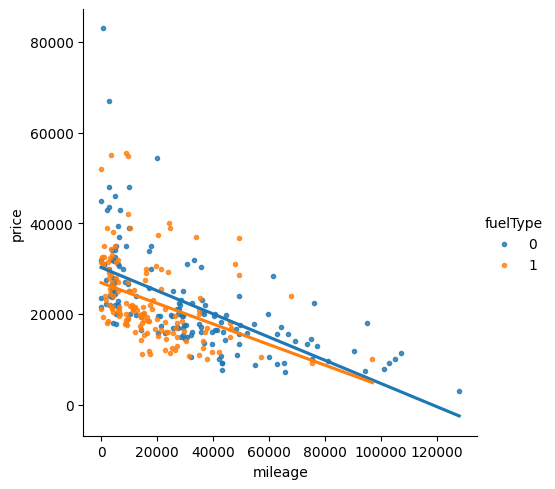

In [481]:
sns.lmplot(data=df.sample(n = 300), x='mileage', y='price', hue='fuelType', ci=False, markers='.')

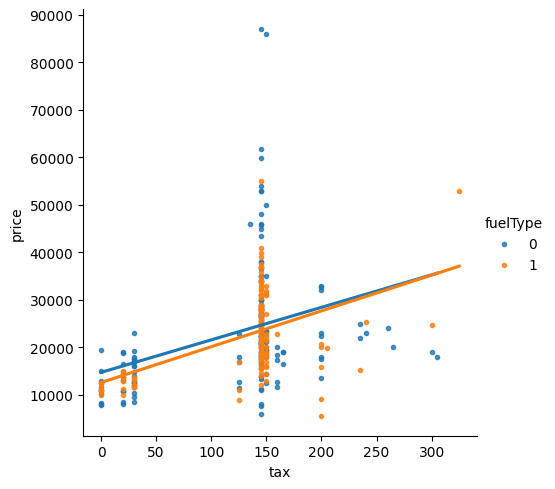

In [482]:
sns.lmplot(data=df.sample(n = 300), x='tax', y='price', hue='fuelType', ci=False, markers='.')

###  Прогнозирование для модели регрессии

Рассморим 10 человек

In [483]:
new_df = df.sample(10)
new_df = new_df.drop(labels={'transmission', 'model', 'price'}, axis=1)
new_df

,year,mileage,fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,SemiAuto
5831,22,12697,0,145,32.8,3.0,0,1,0,0,0,1,0,0
10177,19,35000,0,125,58.9,2.0,1,0,0,0,0,0,1,0
9142,19,39255,0,20,70.6,1.6,1,0,0,0,0,1,0,0
5205,19,28894,1,30,58.9,1.4,1,0,0,0,0,0,1,0
925,19,36399,0,125,60.1,3.0,1,0,0,0,0,1,0,0
652,22,10434,1,145,42.2,1.5,1,0,0,0,0,1,0,0
10481,22,3215,1,150,44.8,1.5,1,0,0,0,0,1,0,0
8813,20,27626,1,150,67.3,1.0,1,0,0,0,0,0,1,0
8459,22,9999,0,145,38.2,2.0,0,1,0,0,0,1,0,0
2616,20,15751,0,145,65.7,2.0,1,0,0,0,0,0,0,1


In [484]:
mod.predict(exog=new_df, transform=True)

5831     10.684025
10177     9.600063
9142      9.569265
5205      9.448489
925      10.030969
652      10.097243
10481    10.121153
8813      9.451776
8459     10.375659
2616      9.868743
dtype: float64

Непосредственное вычисление $\hat{\beta}_0+\hat{\beta}_1x_1+\cdots+\hat{\beta}_kx_k$ для каждого наблюдения.

В матричном виде $X\hat{\beta}$, где $X$ состоит из значений переменных по столбцам + первый столбец из единиц для учёта $\beta_0$

###  Мультиколлинеарность

Какие регрессии нужно рассматривать для вычисления показателей VIF для коэффициентов mpg, tax, fuelType?


Ответ:


**mpg~year+np.log(mileage)+fuelType+tax+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto**


**tax~year+np.log(mileage)+fuelType+mpg+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto**


**fuelType~year+np.log(mileage)+tax+mpg+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto**

In [485]:
mod1 = smf.ols(formula='mpg~year+np.log(mileage)+fuelType+tax+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto', data=df).fit()
mod2 = smf.ols(formula='tax~year+np.log(mileage)+fuelType+mpg+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto', data=df).fit()
mod3 = smf.ols(formula='fuelType~year+np.log(mileage)+tax+mpg+engineSize+A+Q+R+S+T+Automatic+Manual+SemiAuto', data=df).fit()
#Результаты подгонки
# info_dict = {'No. Observations': lambda x: '{0:d}'.format(int(x.nobs)), 
#              'R-squared': lambda x: "%#8.3f" % x.rsquared,
#              'Adj. R-squared': lambda x: "%#8.3f" % x.rsquared_adj,
#              'Residual Std. Error': lambda x: "%#8.3f" % x.mse_resid**0.5,
#              'F-statistic': lambda x: '{:.3f}'.format(x.fvalue), 
#              'Prob (F-statistic)': lambda x: '{:.3f}'.format(x.f_pvalue)
#              }

print(summary_col([mod1, mod2, mod3], stars=True, float_format='%.3f'))


                   mpg        tax      fuelType
-----------------------------------------------
A               11.437***  25.148***  0.172*** 
                (0.298)    (2.082)    (0.015)  
Automatic       15.062***  88.696***  0.542*** 
                (0.360)    (2.414)    (0.018)  
Intercept       48.152***  245.666*** 1.799*** 
                (1.002)    (6.897)    (0.051)  
Manual          17.156***  70.082***  0.616*** 
                (0.327)    (2.324)    (0.017)  
Q               6.104***   43.277***  -0.039** 
                (0.311)    (2.046)    (0.015)  
R               14.408***  75.867***  0.991*** 
                (0.604)    (4.026)    (0.029)  
R-squared       0.676      0.475      0.481    
R-squared Adj.  0.676      0.475      0.480    
S               8.003***   62.806***  0.357*** 
                (0.820)    (5.401)    (0.040)  
SemiAuto        15.935***  86.888***  0.641*** 
                (0.369)    (2.505)    (0.019)  
T               8.199***   38.568***  0

In [486]:
VIF_1 = 1/(1 - mod1.rsquared)
VIF_1.round(2)

3.09

In [487]:
VIF_2 = 1/(1 - mod2.rsquared)
VIF_2.round(2)

1.91

In [488]:
VIF_1 = 1/(1 - mod3.rsquared)
VIF_1.round(2)

1.93

Корреляции между регрессорами

In [489]:
summary_params(mod)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,4.663451,0.023012,202.652149,0.000000e+00,4.618343,4.708559
year,0.132614,0.000978,135.622877,0.000000e+00,0.130697,0.134531
np.log(mileage),-0.026014,0.001432,-18.169648,1.116710e-72,-0.028820,-0.023207
fuelType,0.033233,0.004133,8.040302,9.910834e-16,0.025131,0.041336
tax,0.000106,0.000031,3.470295,5.219446e-04,0.000046,0.000166
mpg,-0.002786,0.000202,-13.814161,4.914607e-43,-0.003182,-0.002391
engineSize,0.299534,0.003739,80.115122,0.000000e+00,0.292205,0.306863
A,0.775725,0.006612,117.312201,0.000000e+00,0.762763,0.788687
Q,0.925354,0.006589,140.445801,0.000000e+00,0.912439,0.938269
R,1.111001,0.012908,86.072586,0.000000e+00,1.085699,1.136302


In [490]:
# Матрицы регрессионного дизайна
y, X = patsy.dmatrices(specification, df, return_type='dataframe')
X.head()

,Intercept,year,np.log(mileage),fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,SemiAuto
0,1.0,20.0,9.663643,1.0,150.0,55.4,1.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,19.0,10.496897,0.0,20.0,64.2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,19.0,10.307151,1.0,30.0,55.4,1.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,20.0,10.164004,0.0,145.0,67.3,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,22.0,7.599902,1.0,145.0,49.6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [491]:
# Удалим первый столбец с единицами
# X.drop(labels='Intercept', axis=1)
# Корреляционная матрицы для регрессоров
X.drop(labels='Intercept', axis=1).corr().round(3)

,year,np.log(mileage),fuelType,tax,mpg,engineSize,A,Q,R,S,T,Automatic,Manual,SemiAuto
year,1.000,-0.678,0.122,0.093,-0.351,-0.032,-0.150,0.189,0.001,-0.051,-0.071,0.110,-0.272,0.181
np.log(mileage),-0.678,1.000,-0.134,-0.185,0.421,0.011,0.154,-0.168,-0.026,0.032,0.030,-0.141,0.213,-0.091
fuelType,0.122,-0.134,1.000,0.103,-0.321,-0.369,0.008,-0.085,0.129,0.018,0.110,-0.110,0.067,0.031
tax,0.093,-0.185,0.103,1.000,-0.636,0.393,-0.382,0.297,0.232,0.097,0.060,0.203,-0.358,0.186
mpg,-0.351,0.421,-0.321,-0.636,1.000,-0.366,0.425,-0.345,-0.210,-0.076,-0.074,-0.205,0.385,-0.212
engineSize,-0.032,0.011,-0.369,0.393,-0.366,1.000,-0.192,0.090,0.331,0.098,0.020,0.248,-0.408,0.196
A,-0.150,0.154,0.008,-0.382,0.425,-0.192,1.000,-0.893,-0.155,-0.095,-0.226,-0.047,0.134,-0.096
Q,0.189,-0.168,-0.085,0.297,-0.345,0.090,-0.893,1.000,-0.088,-0.054,-0.128,0.029,-0.124,0.103
R,0.001,-0.026,0.129,0.232,-0.210,0.331,-0.155,-0.088,1.000,-0.009,-0.022,0.073,-0.098,0.035
S,-0.051,0.032,0.018,0.097,-0.076,0.098,-0.095,-0.054,-0.009,1.000,-0.014,0.087,-0.045,-0.033


<Axes: >

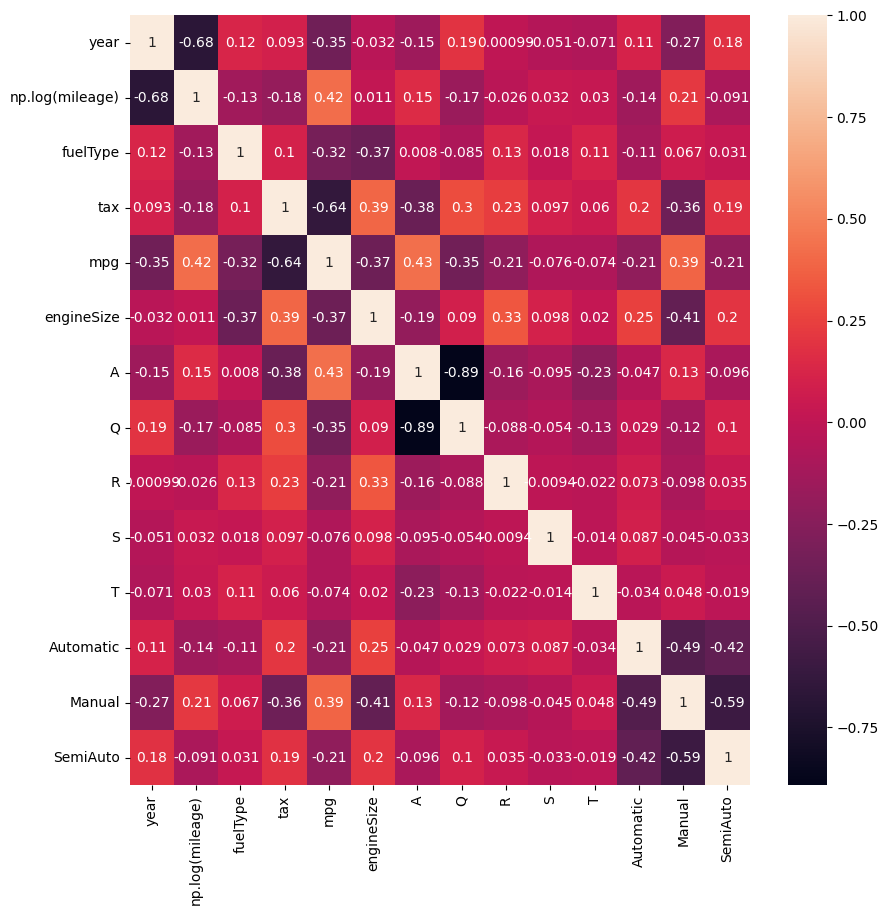

In [492]:
# Визуализация корреляционной матрицы
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.heatmap(X.drop(labels='Intercept', axis=1).corr(), annot=True)

**Вывод:**
 1) между Q и A сильная обратная корелляция
 2) есть сильная зависимость межлду mpg и mileage, что хорошо поддается логике
 3) налог в большенсвте стран напрямую зависит от объема двигателя, поэтому между tax и engineSize прямая корелляция

### 15. Тесты на спецификацию

RESET-тест (неробастный!) со степенями главных компонент (до 4й)

Гипотеза: $H_0:\beta_{MathScore^2}=\beta_{MathScore^3}=\beta_{MathScore^4}=0$

In [493]:
linear_reset(mod, power=4, test_type='princomp', use_f=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=7.186667183285677, p=8.133703527544391e-05, df_denom=1.07e+04, df_num=3>

In [494]:
alpha = 0.05
F_cr = stats.f.ppf(1-0.05,5,len(df)-18)
F_cr.round(2)

2.21

**Вывод: Гипотеза отвергается, регрессия не согласуется с данными**

###  Диагностические тесты на гетероскедастичность
**Выбререм уровень значимости 1%**

Для тестрования нужна матрица наблюдений регрессоров модели. Её можно получить как `mod.model.exog`

**BP-тест** 

Модель гетероскедастичности $Var(u_i|X)=f(\gamma_0+\gamma_1x_1+\cdots+\gamma_kx_k)$

Тестируем $H_0:\begin{pmatrix} \gamma_1 & \cdots & \gamma_k \end{pmatrix}=0$ vs $H_1:\begin{pmatrix} \gamma_1 & \cdots & \gamma_k \end{pmatrix}\ne 0$

*Нулевая гипотеза*: гомоскедаастичность ошибки

*Альтернатива*: гетероскедастиность ошибки

*Промежуточная регрессия*: $e^2$ на регрессоры модели

In [495]:
BP_stat, p_val, F_stat, p_val_F = sms.het_breuschpagan(resid=mod.resid, exog_het=mod.model.exog)
BP_stat, p_val

(831.2656436862053, 2.260399121791779e-168)

1%-критическое значение распределения $\chi^2_{df}$

In [496]:
chi2.ppf(q=1-0.01, df=math_eq.df_model)

27.68824961045705

**Вывод**: тест указывает на гетероскедастиность (тестируемая гипотеза отвергается)

**White-тест** (общий случай)

Тестируем $H_0:Var(u_i|X)=\sigma^2$ vs $H_1:Var(u_i|X)=\sigma^2_i$

*Нулевая гипотеза*: гомоскедаастичность ошибки

*Альтернатива*: гетероскедастиность ошибки (общего вида)

*Промежуточная регрессия*: $e^2$ на регрессоры модели, их квадраты и попарные произведения

In [497]:
test_stat, p_val, F_stat, pval_f = sms.het_white(resid=mod.resid, exog=mod.model.exog)
test_stat, p_val

(4235.652350427527, 0.0)

**Вывод**: тест указывает на  гетероскедастиность (тестируемая гипотезаотвергается) .т.к. $p\_val<\alpha$

###  Робастный t-test

Подгоним модель с поправкою на гетероскедастичность (робастная HC3-оценка ковариационной матрицы)

In [498]:
mod_hc=smf.ols(formula=specification, data=df).fit(cov_type='HC3')
mod_hc.summary(slim=True)

/Users/kirillmirchevskiy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
No. Observations:               10668   F-statistic:                 3.863e+06
Covariance Type:                  HC3   Prob (F-statistic):               0.00
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.6635      0.043    107.380      0.000       4.578       4.749
year                0.1326      0.002     79.113      0.000       0.129       0.136
np.log(mileage)    -0.0260      0.002    -13.069      0.000      -0.030      -0.022
fuelType            0.0332      0.007      4.675      0.000       0.019       0.047
tax                 0.0001   4.76e-05      2.229      0.026    1.28e-05       0.000
mpg                -0.0028      0.001     -4.965      0.000      -0.004      -0.002
engineSize          0.2995      0.007     41.994      0.000       0.286       0.314
A                   0.7757      0.012     64.717      0.000       0.752       0.799
Q                   0.9254      0.011     86.313      0.000       0.904       0.946
R                   1.1110      0.018     63.369      0.000       1.077       1.145
S                   0.9696      0.036     26.709      0.000       0.898       1.041
T                   0.8818      0.012     72.281      0.000       0.858       0.906
Automatic           1.6009      0.015    109.193      0.000       1.572       1.630
Manual              1.4652      0.015     99.790      0.000       1.436       1.494
SemiAuto            1.5973      0.015    107.849      0.000       1.568       1.626
===================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 7.11e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Сравним результаты и исходной оценкой модели

In [499]:
summary_col(results=[mod, mod_hc], stars=True, model_names=['OLS-s.e.', 'HC3-s.e.'])

,OLS-s.e.,HC3-s.e.
Intercept,4.6635***,4.6635***
,(0.0230),(0.0434)
year,0.1326***,0.1326***
,(0.0010),(0.0017)
np.log(mileage),-0.0260***,-0.0260***
,(0.0014),(0.0020)
fuelType,0.0332***,0.0332***
,(0.0041),(0.0071)
tax,0.0001***,0.0001**
,(0.0000),(0.0000)


**Вывод:** Неробастная и робастная тестовая статистики почти совпадают, следовательно влияние ошибок моделирования на характеристики регрессионной модели незначимо.

##  Вывод: 
1) Проведен анализ датасета автомобилей audi с целевой пременной price
2) Данные были правильно преобразованы и приведены в удобный для исследования вид
3) Использовалась визуализация даных для лучшего понимания внутреннего строения зависимостей
4) В ходе работы удолось достичь хорошей точности предсказания целевой переменной
5) Проверено множество гипотез как о коэффицентах так и о модели в целом
6) Исследовано множество корреляций и зависимостей
7) Все шаги анализа подкреплены логичными выводами